In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem import rdFMCS

# Preprocessing

## Load data and compute descriptors & features

In [35]:
# Load data
tested = pd.read_csv("data/tested_molecules.csv")
smiles = tested['SMILES']
mols = [Chem.MolFromSmiles(smi) for smi in smiles]

### 2D descriptors

In [36]:
# 2D Descriptors
desc_list = [x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)
rdkit_desc = [calc.CalcDescriptors(m) for m in mols]  # our rdkit descriptors: 1116 rows by 210 cols

# Create 2d descriptor dataframe
desc_names = calc.GetDescriptorNames()
df_desc_2d = pd.DataFrame(rdkit_desc, index = smiles, columns=desc_names)

### ECFP6 fingerprints

In [37]:
# Binary (Morgan) ECFP6 fingerprints
radius = 3  # 2 for similarity exploration, 3 for ML
nBits = 1024  # 2048 is default, 1024 is also fine

# Calculate binary ECFP6 fingerprints:
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(m , radius = radius, nBits = nBits) for m in mols]

# Create fingerprint dataframe where each column represents a bit
fprint_cols = [f'Bit_{i}' for i in range(1, nBits + 1)]
fprint_bits = [list(x) for x in fingerprints]
df_fprint = pd.DataFrame(fprint_bits, index = smiles, columns = fprint_cols)

### MACCS keys

In [38]:
# MACCS keys
maccs_keys = np.array([MACCSkeys.GenMACCSKeys(m) for m in mols])
col_name = [f'feature_{i}' for i in range(1, len(maccs_keys[0]) + 1)]

# Create MACCS dataframe where each column corresponds to a MACCS feature (structural feature)
df_maccs = pd.DataFrame(data = maccs_keys, index = smiles, columns = col_name)

### Molecular Quantum Numbers

In [39]:
# MQNs
mqn_ds = [rdMolDescriptors.MQNs_(m) for m in mols]
col_name = [f'mqn_{i}' for i in range(1, len(mqn_ds[0]) + 1)]

# Create MQN dataframe where each column corresponds to an MQN feature
df_mqn = pd.DataFrame(data = mqn_ds, index = smiles, columns = col_name)

## Feature selection

In [104]:
def divide_to_inhibitor_groups(df):
    group_00 = df.loc[(df['PKM2_inhibition'] == 0) & (df['ERK2_inhibition'] == 0)]
    group_01 = df.loc[(df['PKM2_inhibition'] == 0) & (df['ERK2_inhibition'] == 1)]
    group_10 = df.loc[(df['PKM2_inhibition'] == 1) & (df['ERK2_inhibition'] == 0)]
    group_11 = df.loc[(df['PKM2_inhibition'] == 1) & (df['ERK2_inhibition'] == 1)]
    return group_00, group_01, group_10, group_11

def drop_single_value_columns(df, log=False):
    new_df = df.copy()
    single_value_columns = [col for col in df.columns if len(set(df[col])) == 1]
    new_df.drop(single_value_columns, axis=1, inplace=True)
    if log:
        print(f"> Dropped {len(single_value_columns)} columns that contain only one value")
    return new_df, single_value_columns

def drop_high_correlation_columns(df, threshold=0.9, show=False, log=False):
    # Copy df to prevent unwanted changes to original
    new_df = df.copy()
    # Create correlation matrix
    corr_matrix = new_df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    # Drop features 
    new_df.drop(to_drop, axis=1, inplace=True)
    # Show changes to columns
    if log:
        print(f"> Dropped {len(to_drop)} columns of higher than {threshold} correlation")
    # Show old and new correlation matrix
    if show:
        plt.matshow(df_desc_2d.corr().abs())
        plt.matshow(new_df.corr().abs())
        plt.show()
    
    return new_df, to_drop

def drop_low_unique_columns(df, tested, nunique_threshold, occurence_threshold, log=False):
    # Copy df to prevent unwanted changes to original
    new_df = df.copy()
    # Collect inhibitor data
    group_00, group_01, group_10, group_11 = divide_to_inhibitor_groups(tested)
    group_inhibitor = pd.concat([group_01, group_10, group_11], axis=0)
    inhibitors = new_df[new_df.index.isin(group_inhibitor["SMILES"])]
    # Number of unique values per column
    number_uniques_per_column = new_df.nunique()
    # Number of non zero values per column
    number_non_zero_per_column = new_df.astype(bool).sum(axis=0)
    # Determine which features to drop
    to_drop = []
    for col, num in number_uniques_per_column.items():
        # Number of unique values must be below set threshold
        if num < nunique_threshold:
            # Number of non zero values must be below set threshold
            if number_non_zero_per_column[col] < occurence_threshold:
                # Don't drop data that describes inhibitors, because the available data is so small already
                if inhibitors[col].astype(bool).sum(axis=0) == 0:
                    to_drop.append(col)
    # Drop features 
    new_df.drop(to_drop, axis=1, inplace=True)
    # Show changes to columns
    if log:
        print(f"> Dropped {len(to_drop)} columns of lower than {nunique_threshold} unique entries that occur less than {occurence_threshold} times")
        
    return new_df, to_drop

def drop_low_variance_columns(df, tested, threshold, log=False):
    # Copy df to prevent unwanted changes to original
    new_df = df.copy()
    # Collect inhibitor data
    group_00, group_01, group_10, group_11 = divide_to_inhibitor_groups(tested)
    group_inhibitor = pd.concat([group_01, group_10, group_11], axis=0)
    inhibitors = df[df.index.isin(group_inhibitor["SMILES"])]
    # Determine variance per column
    variance_per_column = new_df.var()
    # Determine which features to drop
    to_drop = []
    for col, var in variance_per_column.items():
        # print(var)
        # Variance must be lower than threshold
        if var < threshold:
            # Don't drop data that describes inhibitors, because the available data is so small already
            if inhibitors[col].astype(bool).sum(axis=0) == 0:
                to_drop.append(col)
    # Drop features 
    new_df.drop(to_drop, axis=1, inplace=True)
    # Show changes to columns
    if log:
        print(f"> Dropped {len(to_drop)} columns of lower than {threshold} variance")
    
    return new_df, to_drop

def clean_data(df, corr_threshold=0, var_threshold=0, nunique_threshold=0, occurence_threshold=0, show_corr=False, log=True):
    new_df = drop_single_value_columns(df, log=log)
    if corr_threshold:
        new_df = drop_high_correlation_columns(new_df, threshold=corr_threshold, show=show_corr, log=log)
    if nunique_threshold and occurence_threshold:
        new_df = drop_low_unique_columns(new_df, nunique_threshold=nunique_threshold, occurence_threshold=occurence_threshold, log=log)
    if var_threshold:
        new_df = drop_low_variance_columns(new_df, threshold=var_threshold, log=log)
    print("-" *85, f"\nReduced data by {(len(df.columns) - len(new_df.columns)) / len(df.columns)*100:.2f}%: dropped {len(df.columns) - len(new_df.columns)} columns and kept {len(new_df.columns)} columns")
    
    return df

### Selecting 2D descriptors

In [105]:
df = df_desc_2d
df_orig = df
corr_threshold = 0.8
var_threshold = 1.0
nunique_threshold = 10
occurence_threshold = 20
show_corr = False
log=True
desc_2d_dropped_columns = []

df, drop_cols = drop_single_value_columns(df, log=log)
desc_2d_dropped_columns += drop_cols
df, drop_cols = drop_high_correlation_columns(df, threshold=corr_threshold, show=show_corr, log=log)
desc_2d_dropped_columns += drop_cols
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
df, drop_cols = drop_low_unique_columns(df, tested=tested, nunique_threshold=nunique_threshold, occurence_threshold=occurence_threshold, log=log)
desc_2d_dropped_columns += drop_cols
df, drop_cols = drop_low_variance_columns(df, tested=tested, threshold=var_threshold, log=log)
print("-" *85, f"\nReduced data by {(len(df_orig.columns) - len(df.columns)) / len(df_orig.columns)*100:.2f}%: dropped {len(df_orig.columns) - len(df.columns)} columns and kept {len(df.columns)} columns")
cleaned_desc_2d = df.reset_index(drop=True)


> Dropped 23 columns that contain only one value
> Dropped 59 columns of higher than 0.8 correlation
> Dropped 12 columns of lower than 10 unique entries that occur less than 20 times
> Dropped 1 columns of lower than 1.0 variance
------------------------------------------------------------------------------------- 
Reduced data by 45.24%: dropped 95 columns and kept 115 columns


In [42]:
# Save data
cleaned_desc_2d.to_csv("data/cleaned_2d_descriptors.csv")

### Selecting ECFP6 fingerprints

In [63]:
df = df_fprint
cleaned_fprint = df.copy()  # Fingerprints need to be kept whole
cleaned_fprint = df.reset_index(drop=True)

In [64]:
# Save data
cleaned_fprint.to_csv("data/cleaned_fingerprints.csv")

### Selecting MACCS features

In [45]:
df = df_maccs
df_orig = df
corr_threshold = 0.8
var_threshold = 1.0
nunique_threshold = 10
occurence_threshold = 20
show_corr = False
log=True
maccs_dropped_columns = []

df, drop_cols = drop_single_value_columns(df, log=log)
maccs_dropped_columns += drop_cols
df, drop_cols = drop_high_correlation_columns(df, threshold=corr_threshold, show=show_corr, log=log)
maccs_dropped_columns += drop_cols
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
df, drop_cols = drop_low_unique_columns(df, tested=tested, nunique_threshold=nunique_threshold, occurence_threshold=occurence_threshold, log=log)
maccs_dropped_columns += drop_cols
df, drop_cols = drop_low_variance_columns(df, tested=tested, threshold=var_threshold, log=log)
print("-" *85, f"\nReduced data by {(len(df_orig.columns) - len(df.columns)) / len(df_orig.columns)*100:.2f}%: dropped {len(df_orig.columns) - len(df.columns)} columns and kept {len(df.columns)} columns")
cleaned_maccs = df.reset_index(drop=True)

> Dropped 24 columns that contain only one value
> Dropped 26 columns of higher than 0.8 correlation
> Dropped 7 columns of lower than 10 unique entries that occur less than 20 times
> Dropped 0 columns of lower than 1.0 variance
------------------------------------------------------------------------------------- 
Reduced data by 34.13%: dropped 57 columns and kept 110 columns


In [46]:
# Save data
cleaned_maccs.to_csv("data/cleaned_maccs_keys.csv")

### Selecting MQN features

In [47]:
df = df_mqn
df_orig = df
corr_threshold = 0.8
var_threshold = 1.0
nunique_threshold = 10
occurence_threshold = 20
show_corr = False
log=True
mqn_dropped_columns = []

df, drop_cols = drop_single_value_columns(df, log=log)
mqn_dropped_columns += drop_cols
df, drop_cols = drop_high_correlation_columns(df, threshold=corr_threshold, show=show_corr, log=log)
mqn_dropped_columns += drop_cols
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns, index=df.index)
df, drop_cols = drop_low_unique_columns(df, tested=tested, nunique_threshold=nunique_threshold, occurence_threshold=occurence_threshold, log=log)
mqn_dropped_columns += drop_cols
df, drop_cols = drop_low_variance_columns(df, tested=tested, threshold=var_threshold, log=log)
print("-" *85, f"\nReduced data by {(len(df_orig.columns) - len(df.columns)) / len(df_orig.columns)*100:.2f}%: dropped {len(df_orig.columns) - len(df.columns)} columns and kept {len(df.columns)} columns")
cleaned_mqn = df.reset_index(drop=True)

> Dropped 4 columns that contain only one value
> Dropped 6 columns of higher than 0.8 correlation
> Dropped 3 columns of lower than 10 unique entries that occur less than 20 times
> Dropped 0 columns of lower than 1.0 variance
------------------------------------------------------------------------------------- 
Reduced data by 30.95%: dropped 13 columns and kept 29 columns


In [48]:
# Save data
cleaned_mqn.to_csv("data/cleaned_mqn.csv")

# Untested data preparation

## Load data

In [49]:
# Load data
untested = pd.read_csv("data/untested_molecules-3.csv")
untested_smiles = untested['SMILES']
untested_mols = [Chem.MolFromSmiles(smi) for smi in untested_smiles]


### 2D descriptors


In [50]:
# 2D Descriptors
desc_list = [x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)
rdkit_desc = [calc.CalcDescriptors(m) for m in untested_mols]

# Create 2d descriptor dataframe
desc_names = calc.GetDescriptorNames()
df_desc_2d_untested = pd.DataFrame(rdkit_desc, index=untested_smiles, columns=desc_names)


### ECFP6 fingerprints


In [52]:
# Binary (Morgan) ECFP6 fingerprints
radius = 3  # 2 for similarity exploration, 3 for ML
nBits = 1024  # 2048 is default, 1024 is also fine

# Calculate binary ECFP6 fingerprints:
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(m , radius = radius, nBits = nBits) for m in untested_mols]

# Create fingerprint dataframe where each column represents a bit
fprint_cols = [f'Bit_{i}' for i in range(1, nBits + 1)]
fprint_bits = [list(x) for x in fingerprints]
df_fprint_untested = pd.DataFrame(fprint_bits, index = untested_smiles, columns = fprint_cols)

### MACCS keys


In [53]:
# MACCS keys
maccs_keys = np.array([MACCSkeys.GenMACCSKeys(m) for m in untested_mols])
col_name = [f'feature_{i}' for i in range(1, len(maccs_keys[0]) + 1)]

# Create MACCS dataframe where each column corresponds to a MACCS feature (structural feature)
df_maccs_untested = pd.DataFrame(data = maccs_keys, index = untested_smiles, columns = col_name)


### Molecular Quantum Numbers


In [54]:
# MQNs
mqn_ds = [rdMolDescriptors.MQNs_(m) for m in untested_mols]
col_name = [f'mqn_{i}' for i in range(1, len(mqn_ds[0]) + 1)]

# Create MQN dataframe where each column corresponds to an MQN feature
df_mqn_untested = pd.DataFrame(data = mqn_ds, index = untested_smiles, columns = col_name)

### Selecting 2D descriptors


In [55]:
df = df_desc_2d_untested.copy()
df.drop(desc_2d_dropped_columns, axis=1, inplace=True)
untested_desc_2d = df.reset_index(drop=True)

In [56]:
# Save data
untested_desc_2d.to_csv("data/untested_2d_descriptors.csv")

### Selecting ECFP6 fingerprints


In [65]:
df = df_fprint_untested.copy()
untested_fprint = df.reset_index(drop=True)

In [66]:
# Save data
untested_fprint.to_csv("data/untested_fingerprints.csv")

### Selecting MACCS features


In [59]:
df = df_maccs_untested.copy()
df.drop(maccs_dropped_columns, axis=1, inplace=True)
untested_maccs = df.reset_index(drop=True)

In [60]:
# Save data
untested_maccs.to_csv("data/untested_maccs_keys.csv")

### Selecting MQN features

In [61]:
df = df_mqn_untested.copy()
df.drop(mqn_dropped_columns, axis=1, inplace=True)
untested_mqn = df.reset_index(drop=True)

In [62]:
# Save data
untested_mqn.to_csv("data/untested_mqn.csv")

# EDA

## Testing correlation with inhibition

In [ ]:
merged_df = pd.merge(df_fprint, tested, on='SMILES')

df = merged_df.copy()
single_value_columns = [col for col in df.columns if len(set(df[col])) == 1]
df.drop(single_value_columns, axis=1, inplace=True)

# Create correlation matrix
corr_matrix = df.corr().abs()
# print(corr_matrix.iloc[:, -1:])
print(max(corr_matrix["ERK2_inhibition"]))
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find features with correlation greater than threshold
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
# Drop features 
df.drop(to_drop, axis=1, inplace=True)
# Show changes to columns
print(f" Dropped {len(single_value_columns)} single value columns\n",
      f"Dropped {len(to_drop)} columns of higher than {threshold} correlation\n",
      f"Reduced data by {(len(df_desc_2d.columns) - len(df.columns)) / len(df_desc_2d.columns)*100:.2f}% to {len(df.columns)} columns")
# Show old and new correlation matrix
plt.matshow(merged_df.corr().abs().iloc[:, -2:])
plt.matshow(df.corr().abs())
plt.show()

## Tanimoto Similarity (ECFP4)

In [ ]:
esol_data = tested.copy()

ref_smiles = 'O=C(C1CCC1)N1CCc2cc(S(=O)(=O)Nc3ccc4c(c3)OCO4)ccc21'
ref_mol = Chem.MolFromSmiles(ref_smiles)
ref_ECFP4_fps = AllChem.GetMorganFingerprintAsBitVect(ref_mol,3)

PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='SMILES')
bulk_ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,3) for x in esol_data['ROMol']]

similarity_efcp4 = [DataStructs.FingerprintSimilarity(ref_ECFP4_fps,x) for x in bulk_ECFP4_fps]

esol_data['Tanimoto_Similarity (ECFP4)'] = similarity_efcp4
# PandasTools.FrameToGridImage(esol_data.head(8), legendsCol="Tanimoto_Similarity (ECFP4)", molsPerRow=4)

esol_data = esol_data.sort_values(['Tanimoto_Similarity (ECFP4)'], ascending=False)
# PandasTools.FrameToGridImage(esol_data.head(8), legendsCol="Tanimoto_Similarity (ECFP4)", molsPerRow=4)smiles = group_01["SMILES"]


In [86]:

# Function to create grid of similarity scores within inhibitor groups
def similarity_grid(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    df_similarity = pd.DataFrame()

    for index, ref_smiles in enumerate(smiles):
        ref_mol = mols[index]  # Chem.MolFromSmiles(ref_smiles)
        ref_ECFP4_fps = AllChem.GetMorganFingerprintAsBitVect(ref_mol,2)

        bulk_ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in mols]

        similarity_efcp4 = pd.Series([DataStructs.FingerprintSimilarity(ref_ECFP4_fps,x) for x in bulk_ECFP4_fps])

        df_similarity = pd.concat((df_similarity, similarity_efcp4.rename(smiles)), axis=1)
    
    df_similarity.columns = smiles
    df_similarity.index = smiles
    plt.matshow(df_similarity)
    plt.show()
    return df_similarity

# df_similarity = similarity_grid(group_01)

# Save result
# df_similarity.to_csv("data/similarity_10.csv")

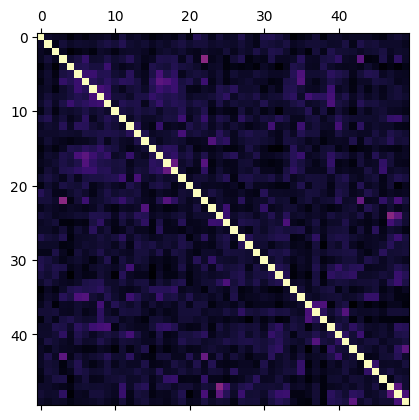

In [109]:
df_similarity = pd.read_csv("data/similarity_01.csv").set_index("SMILES")
max_similarity_per_col = [df_similarity[col].nlargest(2).iloc[1] for col in df_similarity.columns]
plt.matshow(df_similarity, cmap='magma')
plt.show()

## Most Common Substructure (MCS)

In [ ]:
group_00, group_01, group_10, group_11 = divide_to_inhibitor_groups(tested)
smiles = group_10["SMILES"]

mols = [Chem.MolFromSmiles(smi) for smi in smiles]

res = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True)
print(res.smartsString)
res_mol = Chem.MolFromSmarts(res.smartsString)
res_mol

In [ ]:
highlight_mcs = [mMol.GetSubstructMatch(res_mol) for mMol in mols]
Draw.MolsToGridImage(mols, 
                     highlightAtomLists = highlight_mcs,
                     subImgSize=(250,250), useSVG=False, molsPerRow=4)

### Check substructures manually

Substructure: c1ccccc1S(=O)(=O)N, Frequency: 122, Percentage: 10.93%


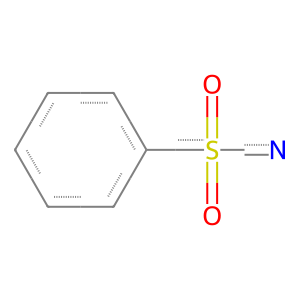

Substructure: csc, Frequency: 152, Percentage: 13.62%


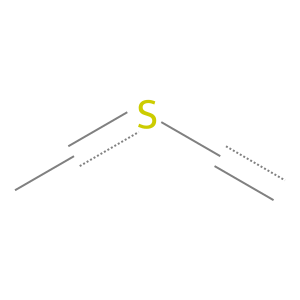

In [110]:
from collections import defaultdict

# Chose the data set to count the substructers in.
data_set = mols

# Chose the substructers to be searched.
substructers_smarts = [
    'c1ccccc1S(=O)(=O)N',
    'csc'
    ]

substructers = [Chem.MolFromSmarts(smarts) for smarts in substructers_smarts]

# Counter to determine the frequency of the structers in the molecules.
counter = defaultdict(int)

# add one to the counter for every molecule with the substructure.
for mol in data_set:
    for substruct in substructers:
        if mol.HasSubstructMatch(substruct):
            counter[Chem.MolToSmarts(substruct)] += 1

# Return the molecule with their smiles, frequency and the percentage of this structure in the set.
for sub, freq in sorted(counter.items(), key=lambda x: x[1]):
    print(f"Substructure: {sub}, Frequency: {freq}, Percentage: {freq/len(data_set)*100:.2f}%")
    sub_mol = Chem.MolFromSmarts(sub)
    display(Draw.MolToImage(sub_mol))